<a href="https://colab.research.google.com/github/Manas-Todi/STYLE-SWAP/blob/main/Task%203/task%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import time

In [ ]:
!gdown 1LvXH0NLp-jwI2FVkl9HgH6urv64xA0Jq

Downloading...
From (original): https://drive.google.com/uc?id=1LvXH0NLp-jwI2FVkl9HgH6urv64xA0Jq
From (redirected): https://drive.google.com/uc?id=1LvXH0NLp-jwI2FVkl9HgH6urv64xA0Jq&confirm=t&uuid=66599831-a4bb-428d-bc4e-90d64d08c90f
To: /content/pokemon.zip
100% 120M/120M [00:00<00:00, 144MB/s]


In [ ]:
!unzip /content/pokemon.zip

Archive:  /content/pokemon.zip
replace pokemon/692/692-16.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
transform = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor()])
orignal = torchvision.datasets.ImageFolder(r'/content/pokemon',transform = transform)

In [ ]:
orignal=torch.utils.data.DataLoader(orignal,batch_size=128,drop_last=True,shuffle=True)

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class generator(nn.Module):

    def __init__(self):
        super(generator, self).__init__()

        self.fc1=nn.Linear(100,8*8*1024)

        self.conv_layers = nn.Sequential(

        nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4 , stride=2, padding =1,bias=False),
        nn.BatchNorm2d(512,eps=0.8, momentum=0.1),
        nn.ReLU(),
        # batch norm and relu

        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4 , stride=2, padding =1,bias=False),
        nn.BatchNorm2d(256,eps=0.8, momentum=0.1),
        nn.ReLU(),
        # batch norm and relu

        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4 , stride=2, padding =1,bias=False),
        nn.BatchNorm2d(128,eps=0.8, momentum=0.1),
        nn.ReLU(),
        # batch norm and relu

        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding =1,bias=False),
        nn.BatchNorm2d(64,eps=0.8, momentum=0.1),
        nn.ReLU(),
        # batch norm and relu

        nn.Conv2d(in_channels=64, out_channels=3, kernel_size=5 , stride=1, padding =2,bias=False),
        nn.Tanh(),
        )

    def forward(self, x):
        x=self.fc1(x)
        x=torch.reshape(x,(-1,1024,8,8))
        x = self.conv_layers(x)
        return x

In [ ]:
generator=generator().to(device)
summary(generator, input_size =(100,), batch_size = 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [128, 65536]       6,619,136
   ConvTranspose2d-2         [128, 512, 16, 16]       8,388,608
       BatchNorm2d-3         [128, 512, 16, 16]           1,024
              ReLU-4         [128, 512, 16, 16]               0
   ConvTranspose2d-5         [128, 256, 32, 32]       2,097,152
       BatchNorm2d-6         [128, 256, 32, 32]             512
              ReLU-7         [128, 256, 32, 32]               0
   ConvTranspose2d-8         [128, 128, 64, 64]         524,288
       BatchNorm2d-9         [128, 128, 64, 64]             256
             ReLU-10         [128, 128, 64, 64]               0
  ConvTranspose2d-11        [128, 64, 128, 128]         131,072
      BatchNorm2d-12        [128, 64, 128, 128]             128
             ReLU-13        [128, 64, 128, 128]               0
           Conv2d-14         [128, 3, 1

In [ ]:
class discriminator(nn.Module):

    def __init__(self):
        super(discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=0.8, momentum=0.1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, eps=0.8, momentum=0.1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=0.8, momentum=0.1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=0.8, momentum=0.1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024, eps=0.8, momentum=0.1),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.model(x)


In [ ]:
discriminator=discriminator().to(device)
summary(discriminator, input_size =(3,128,128), batch_size = 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 64, 64]           3,072
       BatchNorm2d-2          [128, 64, 64, 64]             128
         LeakyReLU-3          [128, 64, 64, 64]               0
            Conv2d-4         [128, 128, 32, 32]         131,072
       BatchNorm2d-5         [128, 128, 32, 32]             256
         LeakyReLU-6         [128, 128, 32, 32]               0
            Conv2d-7         [128, 256, 16, 16]         524,288
       BatchNorm2d-8         [128, 256, 16, 16]             512
         LeakyReLU-9         [128, 256, 16, 16]               0
           Conv2d-10           [128, 512, 8, 8]       2,097,152
      BatchNorm2d-11           [128, 512, 8, 8]           1,024
        LeakyReLU-12           [128, 512, 8, 8]               0
           Conv2d-13          [128, 1024, 4, 4]       8,388,608
      BatchNorm2d-14          [128, 102

In [ ]:
criterion = nn.BCELoss()

lr = 0.0002
beta1 = 0.5

optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
hehe=torch.randn(100).to(device)

In [ ]:
generated=generator(hehe)

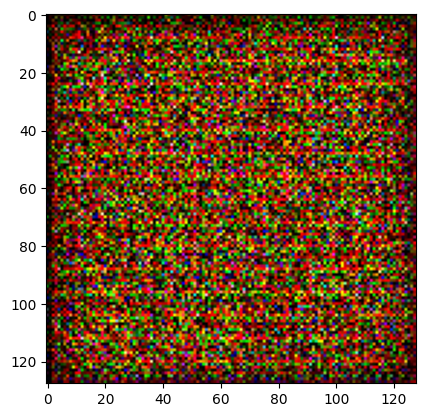

In [ ]:
plt.imshow((generated[0]*255).T.detach().cpu())

In [ ]:
num_epochs = 10
latent_vector_size = 100

for epoch in range(num_epochs):
    t0 = time.time()
    for i, data in enumerate(orignal):
        # Train Discriminator with real data
        discriminator.zero_grad()
        real_data = data[0].to(device)
        # print(real_data.size())
        # real_data = torch.Tensor(real_data)
        batch_size =128
        labels = torch.full((batch_size,), 1, dtype=torch.float).to(device)


        output = discriminator(real_data).view(-1)
        print(output)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        # Train Discriminator with fake data
        noise = torch.randn(batch_size, latent_vector_size).to(device)
        fake_data = generator(noise)
        labels.fill_(0)

        output = discriminator(fake_data.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()

        optimizerD.step()

        # Train Generator
        generator.zero_grad()
        labels.fill_(1)  # We want the generator to fool the discriminator

        output = discriminator(fake_data).view(-1)
        # print(output)
        lossG = criterion(output, labels)
        lossG.backward()

        optimizerG.step()

    plt.subplot(1,20,epoch+1)
    generated=generator(hehe)
    plt.imshow((generated[0]*255).T.detach().cpu())
    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(orignal)}], Loss D: {lossD_real.item() + lossD_fake.item()}, Loss G: {lossG.item()}')
    print('completed in {} seconds'.format(time.time() - t0))

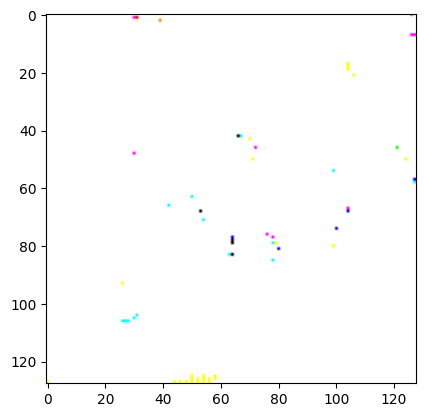

In [ ]:
plt.imshow((generated[0]*255).T.detach().cpu())

In [ ]:
gen=discriminator(generated)

In [ ]:
gen

tensor([[0.0006]], device='cuda:0', grad_fn=<SigmoidBackward0>)